In [1]:
import warnings
warnings.filterwarnings("ignore")
import math, os, sys, copy, pickle
from skimage import io, filters, restoration
from skimage import morphology as morph
import PIL
from PIL import Image, ImageSequence, ImageEnhance
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import glob
import cv2
import multipagetiff as mtif
import tifffile

In [2]:
def plot(tif_files, try_denoise = False):
    fig, axes = plt.subplots(2, 4, figsize=(16,8), sharex=True, sharey=True)
    for num, tif_file in enumerate(tif_files):
        #print(tif_file, tif_file.rsplit(".", 1)[0][-1])
        # num = int(tif_file.rsplit(".", 1)[0][-1])-1
        im = Image.open(tif_file)
        if denoise:
            imarray = denoise(np.array(im))
        else:
            imarray = np.array(im)
        # print(num, num//4, num%4)
        axes[num//4, num%4].imshow(imarray)
        axes[num//4, num%4].set_title("{}".format(num+1))
    plt.show()
    # plt.colorbar()
#     fig.subplots_adjust(right=0.85)
#     cbar_ax = fig.add_axes([0.88, 0.15, 0.04, 0.7])
#     fig.colorbar(im, cax=cbar_ax)
def plot_oneZ(tif_files, z_pos = 0, z_num = 0):
    fig, axes = plt.subplots(2, 4, figsize=(16,8), sharex=True, sharey=True)
    for tif_file in tif_files:
        #print(tif_file, tif_file.rsplit(".", 1)[0][-1])
        num = int(tif_file.rsplit(".", 1)[0][-1])-1
        imgs = mtif.read_stack(tif_file)
        if z_num != 0:
            img = imgs[z_num - 1]
        else:
            img = imgs[math.floor(len(imgs) * z_pos)]
        # print(num, num//4, num%4)
        axes[num//4, num%4].imshow(img)
        axes[num//4, num%4].set_title("{}".format(num+1))
    plt.show()
def plot_single(img):
    #print(tif_file, tif_file.rsplit(".", 1)[0][-1])
    # im = Image.open(tif_file)
    # img = np.array(im)
    plt.figure()
    ax = plt.gca()
    im_vis = ax.imshow(img)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im_vis, cax=cax)
    plt.show()
def flatten_plot(tif_files):
    # fig, axes = plt.subplots(2,4, figsize=(16,8), sharex = True, sharey = True)
    plt.figure(figsize=(16,8))
    for i, tif_file in enumerate(tif_files):
        imgs = mtif.read_stack(tif_file)
        plt.subplot(2,4,i+1)
        img = mtif.flatten(imgs)
        plt.imshow(img)
    plt.tight_layout()

In [3]:
def normalize(img, im_max = None, im_min = 0, scale_to = 65535):
    img_new = copy.deepcopy(img)
    if im_max == None:
        im_max = np.max(img)
    if im_min == None:
        im_min = np.min(img)
    img_new = (img - im_min) / (im_max - im_min)
    img_new = np.array(img_new * scale_to).astype(np.uint16)
    return(img_new)
def filter(img, threshold = None):
    if threshold == None:
        threshold = filters.threshold_otsu(img)
    mask = img > threshold
    otsu_filtered = np.zeros_like(img)
    otsu_filtered[mask] = img[mask]
    return(otsu_filtered)
def filter_z(imgz, threshold = None):
    for i in range(len(imgz)):
        imgz[i] = filter(imgz[i], threshold)
    return(imgz)
def sub_bg_thr(img, threshold = None):
    if threshold == None:
        threshold = filters.threshold_otsu(img)
    img = img - threshold
    img[img < 0] = 0
    return(img)
def sub_bg_thr_z(imgz, threshold = None):
    for i in range(len(imgz)):
        imgz[i] = sub_bg_thr(imgz[i], threshold)
    return(imgz)
def threshold_z(imgz):
    thresholds = [filters.threshold_otsu(img) for img in imgz]
    return(max(thresholds))
def threshold_all(imgs):
    thresholds = [max([filters.threshold_otsu(img) for img in imgz]) for imgz in imgs]
    return(max(thresholds)) 
def remove_background(img, rolling_ball_radius = 25):
    background = restoration.rolling_ball(img, radius=rolling_ball_radius)
    rolling_ball_filtered = img - background
    return(rolling_ball_filtered)
def remove_background_z(imgz, rolling_ball_radius = 25):
    for i in range(len(imgz)):
        imgz[i] = remove_background(imgz[i], rolling_ball_radius)
    return(imgz)
def denoise(img, rolling_ball_filtered = 25, threshold = None):
    return(filter(remove_background(img, rolling_ball_filtered), threshold))
def denoise_z(imgz, rolling_ball_radius = 25, threshold = None):
    imgz_denoised = copy.deepcopy(imgz)
    try:
        for i in range(len(imgz)):
            imgz_denoised[i] = remove_background(imgz[i], rolling_ball_radius)
        if threshold == None:
            threshold = threshold_z(imgz_denoised)
        for i in range(len(imgz)):
            imgz_denoised[i] = filter(imgz_denoised[i], threshold)
    except:
        imgz_denoised = np.zeros_like(imgz)
    return(imgz_denoised)

In [4]:
def sum_z(imgz):
    try:
        img_sum = np.sum(imgz, axis=0)
    except:
        img_sum = np.zeros_like(imgz)
    return(img_sum)
def ave_z(imgz):
    try:
        img_ave = np.mean(imgz, axis=0)
    except:
        img_ave = np.zero_like(imgz)
    return(img_ave)

In [5]:
def simple_stitch(imgs, seq_num = 4, hr_margin = 233, vu_margin = 0):
    images = []
    for i in range(seq_num):
        img = imgs[i]
        if i < 3:
            images.append(img[:,:-hr_margin])
        else:
            images.append(img)
    img1 = np.hstack(images)
    images = []
    for i in range(seq_num):
        img = imgs[i+seq_num]
        if i < 3:
            images.append(img[:,:-hr_margin])
        else:
            images.append(img)
    img2 = np.hstack(images)
    im_h = np.vstack([img1[vu_margin:, :], img2[vu_margin:, :]])
    return(im_h)
def simple_stitch_z(imgs, z_num = None, seq_num = 4, hr_margin = 233, vu_margin = 0):
    if z_num == None:
        z_num = len(imgs[0])
    stitched = []
    for i in range(z_num):
        images = [img[i] for img in imgs]
        stitched.append(simple_stitch(images, seq_num, hr_margin, vu_margin))
    return(np.array(stitched))

In [6]:
def sum_y(img):
    img1d = np.sum(img, axis=0)
    return(img1d)
def slide_sum_y(img, slide_len = 100):
    img1d = np.sum(img, axis=0)
    img_slides = []
    for i in range(0, len(img1d) - slide_len):
        img_slides.append(np.sum(img1d[i:i+slide_len], axis=0))
    return(np.array(img_slides))
def get_pop_density(img1d):
    pop_density = img1d/img1d.sum(axis=1, keepdims=True)
    return(pop_density)

In [7]:
def get_mask(img):
    img[img > 0] = 1
    img = np.abs(1 - img)
    return(img)
def get_mask_inv(img):
    img[img > 0] = 1
    return(img)
def mask_img(img, mask):
    img[mask == 0] = 0
    return(img)
def simple_stitch_z_with_mask(imgs, mask, z_num = None, seq_num = 4, hr_margin = 233, vu_margin = 0):
    if z_num == None:
        z_num = len(imgs[0])
    stitched = []
    for i in range(z_num):
        images = [img[i] for img in imgs]
        stitched.append(mask_img(simple_stitch(images, seq_num, hr_margin, vu_margin), get_mask(mask)))
    return(np.array(stitched))

## Set directories

In [8]:
work_dir = "/Users/feng626/workspace/data/SoilSFA/spatial_interactions"

In [9]:
rep3_dir = work_dir + "/Activity_1.3_rep3_02.07.22_start"
rep3_img_dirs = [name for name in os.listdir(rep3_dir) if os.path.isdir(os.path.join(rep3_dir, name))] 

In [10]:
rep2_dir = work_dir + "/Activity_1.3_rep2_12.13.21_start"
rep2_img_dirs = [name for name in os.listdir(rep2_dir) if os.path.isdir(os.path.join(rep2_dir, name))] 

In [11]:
patch_number = 8

## Work on the rep3

In [11]:
# Stitch all the BF figures and keep z stacks
for chi, channel in enumerate(['w1SD BF']):#, 'w2SD DAPI', 'w3SD GFP', 'w4SD RFP']):
    for dir in rep3_img_dirs:
        img_dir = rep3_dir + '/' + dir 
        tif_files = glob.glob(img_dir + '/' + dir + '_1_{}_s*.TIF'.format(channel))
        tif_files.sort()
        tif_file_new = img_dir + '/' + dir + '_1_{}_stitched.TIF'.format(channel)
        if not os.path.isfile(tif_file_new):
            imgs = [io.imread(tif_file) for tif_file in tif_files]
            if chi == 0:
                imgzn = simple_stitch(imgs)
            else:
                imgzn = simple_stitch_z(imgs)
            io.imsave(tif_file_new, imgzn)

In [ ]:
for chi, channel in enumerate(['w2SD DAPI', 'w3SD GFP', 'w4SD RFP']):
    for dir in rep3_img_dirs:
        if dir == "02.09.22_11AM_Chito5":
            continue
        img_dir = rep3_dir + '/' + dir 
        for i in range(patch_number):
            tif_file = img_dir + '/' + dir + '_1_{}_s{}.TIF'.format(channel, i+1)
            tif_file_new = img_dir + '/' + dir + '_1_{}_s{}_wo_bg.TIF'.format(channel, i+1)
            if not os.path.isfile(tif_file_new):
                imgz = io.imread(tif_file)
                imgzn = remove_background_z(imgz)
                io.imsave(tif_file_new, imgzn)

In [77]:
global_thrs = [50, 50, 250]
result_dir = "./results_rep3"
counter = 0
for dir in rep3_img_dirs:
    if dir == "02.09.22_11AM_Chito5":
        continue
    img_dir = rep3_dir + '/' + dir 
    all_channels = []
    for chi, channel in enumerate(['w4SD RFP', 'w3SD GFP', 'w2SD DAPI']):
        counter += 1
        masked_file = img_dir + '/' + dir + '_1_w1SD BF_stitched_mask.tif'
        tif_files = glob.glob(img_dir + '/' + dir + '_1_{}_s*_wo_bg.TIF'.format(channel))
        tif_files.sort()
        new_tif_file = img_dir + '/' + dir + '_1_{}_wo_bg_stichted_masked.TIF'.format(channel)
        new_summed_tif_file = img_dir + '/' + dir + '_1_{}_wo_bg_stichted_masked_summed.TIF'.format(channel)
        summed_csv_file = result_dir + '/' + dir + '_1_{}_wo_bg_stichted_sub_thr_masked_summed.csv'.format(channel)

        imgs_mask = get_mask(io.imread(masked_file))
        imgs = [io.imread(tif_file) for tif_file in tif_files]
        imgs_filtered = [filter_z(img, global_thrs[chi]) for img in imgs]
        # imgs_filtered = imgs

        imgs_stitched_z = simple_stitch_z(imgs_filtered)
        # imgs_stitched_z = denoise_z(imgs_stitched_z)
        # masked_img_z = imgs_stitched_z
        masked_img_z = np.array([mask_img(imgs_stitched_zi, imgs_mask) for imgs_stitched_zi in imgs_stitched_z])
        # masked_img_z = denoise_z(masked_img_z)
        tifffile.imsave(new_tif_file, masked_img_z)

        # imgi_summed = [sum_z(img) for img in imgs_filtered]
        # imgi_summed = [filter(img, global_thrs[chi]) for img in imgi_summed]
        # imgs_summed = simple_stitch(imgi_summed)
        imgs_summed = sum_z(masked_img_z)
        # imgs_summed = filter(imgs_summed, global_thrs[chi])
        imgs_summed = mask_img(imgs_summed, imgs_mask)
        # imgs_summed = denoise(imgs_summed.astype(np.uint16))
        # imgs_summed = denoise(imgs_summed)
        img_to_merge = normalize(imgs_summed)
        # img_to_merge = imgs_summed
        io.imsave(new_summed_tif_file, img_to_merge)
        np.savetxt(summed_csv_file, img_to_merge, delimiter=',')

        all_channels.append(img_to_merge)
        
    combined_img = np.transpose(all_channels, (1,2,0))
        
    output = result_dir + '/' + dir + '_1_combined_masked_normalized'
    img_out = output + '.TIF'
    pkl_out = output + '.pkl'
    plot_out = output + '_1d.png'
        
    with open(pkl_out, 'wb') as f:
        pickle.dump(combined_img, f)
        
    plt.figure(figsize=(16,8))
    plt.imshow(combined_img)
    plt.savefig(img_out, dpi=300)
    plt.close()

    pop_den = get_pop_density(slide_sum_y(combined_img, combined_img.shape[1]//20))
    colors = ['red', 'green', 'blue']
    plt.figure(figsize=(16,8))
    for i in range(3):
        plt.plot(range(len(pop_den)), pop_den[:,i], color = colors[i], linewidth=3)
    # plt.plot(range(len(pop_den)), pop_den, linewidth=2)
    plt.savefig(plot_out, dpi=300)
    # plt.show()
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

## Work on the rep2

In [ ]:
# Stitch all the BF figures and keep z stacks
for chi, channel in enumerate(['w1SD BF']):#, 'w2SD DAPI', 'w3SD GFP', 'w4SD RFP']):
    for dir in rep2_img_dirs:
        img_dir = rep2_dir + '/' + dir 
        tif_files = glob.glob(img_dir + '/' + dir + '_1_{}_s*.TIF'.format(channel))
        tif_files.sort()
        tif_file_new = img_dir + '/' + dir + '_1_{}_stitched.TIF'.format(channel)
        if not os.path.isfile(tif_file_new):
            imgs = [io.imread(tif_file) for tif_file in tif_files]
            if chi == 0:
                imgzn = simple_stitch(imgs)
            else:
                imgzn = simple_stitch_z(imgs)
            io.imsave(tif_file_new, imgzn)

In [ ]:
for chi, channel in enumerate(['w2SD DAPI', 'w3SD GFP', 'w4SD RFP']):
    for dir in rep2_img_dirs:
        img_dir = rep2_dir + '/' + dir 
        for i in range(patch_number):
            tif_file = img_dir + '/' + dir + '_1_{}_s{}.TIF'.format(channel, i+1)
            tif_file_new = img_dir + '/' + dir + '_1_{}_s{}_wo_bg.TIF'.format(channel, i+1)
            if not os.path.isfile(tif_file_new):
                imgz = io.imread(tif_file)
                imgzn = remove_background_z(imgz)
                io.imsave(tif_file_new, imgzn)

In [66]:
channel_thrs = [75, 250, 250]
global_thr = 250
result_dir = "./results_rep2"
counter = 0
for dir in rep2_img_dirs:
    img_dir = rep2_dir + '/' + dir 
    all_channels = []
    for chi, channel in enumerate(['w4SD RFP', 'w3SD GFP', 'w2SD DAPI']):
        counter += 1
        masked_file = img_dir + '/' + dir + '_1_w1SD BF_stitched_mask.tif'
        tif_files = glob.glob(img_dir + '/' + dir + '_1_{}_s*.TIF'.format(channel))
        tif_files.sort()
        new_tif_file = img_dir + '/' + dir + '_1_{}_wo_bg_stichted_masked.TIF'.format(channel)
        new_summed_tif_file = img_dir + '/' + dir + '_1_{}_wo_bg_stichted_masked_summed.TIF'.format(channel)
        summed_csv_file = result_dir + '/' + dir + '_1_{}_wo_bg_stichted_sub_thr_masked_summed.csv'.format(channel)

        imgs_mask = get_mask(io.imread(masked_file))
        imgs = [io.imread(tif_file) for tif_file in tif_files]
        imgs = [sub_bg_thr_z(img, global_thr) for img in imgs]
        # imgs_filtered = [filter_z(img, global_thrs[chi]) for img in imgs]
        imgs_filtered = [remove_background_z(img) for img in imgs]

        imgs_stitched_z = simple_stitch_z(imgs_filtered)
        # imgs_stitched_z = denoise_z(imgs_stitched_z)
        # masked_img_z = imgs_stitched_z
        masked_img_z = np.array([mask_img(imgs_stitched_zi, imgs_mask) for imgs_stitched_zi in imgs_stitched_z])
        # masked_img_z = denoise_z(masked_img_z)
        tifffile.imsave(new_tif_file, masked_img_z)

        # imgi_summed = [sum_z(img) for img in imgs_filtered]
        # imgi_summed = [filter(img, global_thrs[chi]) for img in imgi_summed]
        # imgs_summed = simple_stitch(imgi_summed)
        imgs_summed = sum_z(masked_img_z)
        # imgs_summed = filter(imgs_summed, global_thrs[chi])
        imgs_summed = mask_img(imgs_summed, imgs_mask)
        # imgs_summed = denoise(imgs_summed.astype(np.uint16))
        # imgs_summed = denoise(imgs_summed)
        img_to_merge = normalize(imgs_summed)
        # img_to_merge = imgs_summed
        io.imsave(new_summed_tif_file, img_to_merge)
        np.savetxt(summed_csv_file, img_to_merge, delimiter=',')

        all_channels.append(img_to_merge)
        
    combined_img = np.transpose(all_channels, (1,2,0))
        
    output = result_dir + '/' + dir + '_1_combined_masked_normalized'
    img_out = output + '.TIF'
    pkl_out = output + '.pkl'
    plot_out = output + '_1d.png'
        
    with open(pkl_out, 'wb') as f:
        pickle.dump(combined_img, f)
        
    plt.figure(figsize=(16,8))
    plt.imshow(combined_img)
    plt.savefig(img_out, dpi=300)
    plt.close()

    pop_den = get_pop_density(slide_sum_y(combined_img, combined_img.shape[1]//20))
    colors = ['red', 'green', 'blue']
    plt.figure(figsize=(16,8))
    for i in range(3):
        plt.plot(range(len(pop_den)), pop_den[:,i], color = colors[i], linewidth=3)
    # plt.plot(range(len(pop_den)), pop_den, linewidth=2)
    plt.savefig(plot_out, dpi=300)
    # plt.show()
    plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

## Get background thresholds

In [19]:
img_dir = "/Users/feng626/workspace/data/SoilSFA/spatial_interactions/02.07.22_NoCellsCtrl"
dir = "02.07.22_NoCellsCtrl"

In [20]:
bg_max = []
imgzns = []
mask_file = img_dir + '/' + dir + '_1_w1SD BF_stitched_mask.tif'
mask = io.imread(mask_file)
for chi, channel in enumerate(['w2SD DAPI', 'w3SD GFP', 'w4SD RFP']):
    tif_files = glob.glob(img_dir + '/' + dir + '_1_{}_s*.TIF'.format(channel))
    tif_files.sort()
    tif_file_new = img_dir + '/' + dir + '_1_{}_stitched_masked.TIF'.format(channel)
    imgs = [io.imread(tif_file) for tif_file in tif_files]
    imgzn = simple_stitch_z_with_mask(imgs, mask)
    bg_max.append(np.nanmax(imgzn))
    io.imsave(tif_file_new, imgzn)
    imgzns.append(imgzn)

/var/folders/8b/r7fd8dvd1b53ns6wtty0dhjs1g0xsn/T/ipykernel_1445/968577506.py:12: UserWarning: /Users/feng626/workspace/data/SoilSFA/spatial_interactions/02.07.22_NoCellsCtrl/02.07.22_NoCellsCtrl_1_w2SD DAPI_stitched_masked.TIF is a low contrast image
  io.imsave(tif_file_new, imgzn)
/var/folders/8b/r7fd8dvd1b53ns6wtty0dhjs1g0xsn/T/ipykernel_1445/968577506.py:12: UserWarning: /Users/feng626/workspace/data/SoilSFA/spatial_interactions/02.07.22_NoCellsCtrl/02.07.22_NoCellsCtrl_1_w3SD GFP_stitched_masked.TIF is a low contrast image
  io.imsave(tif_file_new, imgzn)
/var/folders/8b/r7fd8dvd1b53ns6wtty0dhjs1g0xsn/T/ipykernel_1445/968577506.py:12: UserWarning: /Users/feng626/workspace/data/SoilSFA/spatial_interactions/02.07.22_NoCellsCtrl/02.07.22_NoCellsCtrl_1_w4SD RFP_stitched_masked.TIF is a low contrast image
  io.imsave(tif_file_new, imgzn)


In [21]:
bg_max

[459, 555, 7151]

(0.0, 500.0)

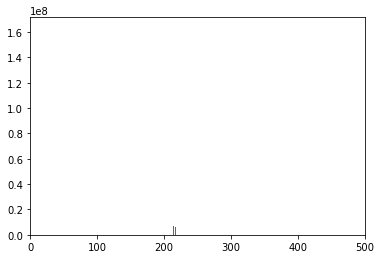

In [22]:
plt.hist(imgzns[0].flatten(),bins=10000)
plt.xlim([0,500])

(0.0, 600.0)

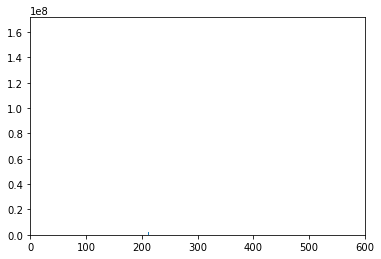

In [23]:
plt.hist(imgzns[1].flatten(),bins=10000)
plt.xlim([0,600])

(0.0, 300.0)

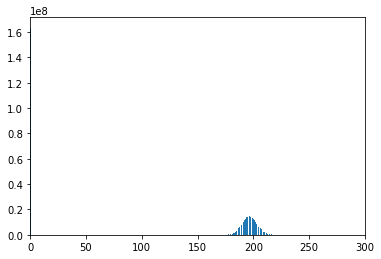

In [24]:
plt.hist(imgzns[2].flatten(),bins=10000)
plt.xlim([0,300])

In [63]:
global_thr = 0

## Subtract backgrounds

In [13]:
image_dir = "/Users/feng626/workspace/data/SoilSFA/spatial_interactions/Activity_1.3_rep1_11.18.21_start"

In [ ]:
for carbon in ["Chitin", "Chito5", "Nag"]:
    time_dir = image_dir + '/' + carbon 
    timepoints = [name for name in os.listdir(time_dir) if os.path.isdir(os.path.join(time_dir, name))] 
    timepoints.sort()
    for timepoint in timepoints:
        all_channels = []
        for chi, channel in enumerate(['w2SD DAPI', 'w3SD GFP', 'w4SD RFP']):
            for i in range(patch_number):
                tif_file = image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_s{}.TIF'.format(channel, i+1)
                tif_file_new = image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_s{}_wo_bg.TIF'.format(channel, i+1)
                imgz = io.imread(tif_file)
                imgzn = remove_background_z(imgz)
                io.imsave(tif_file_new, imgzn)

In [ ]:
# Stitch all the BF figures and keep z stacks
for carbon in ["Chitin", "Chito5", "Nag"]:
    time_dir = image_dir + '/' + carbon 
    timepoints = [name for name in os.listdir(time_dir) if os.path.isdir(os.path.join(time_dir, name))] 
    timepoints.sort()
    for timepoint in timepoints:
        all_channels = []
        channel = "w1SD BF"
        tif_files = glob.glob(image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_s*.TIF'.format(channel))
        tif_files.sort()
        tif_file_new = image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_stitched.TIF'.format(channel)
        imgs = [io.imread(tif_file) for tif_file in tif_files]
        imgzn = simple_stitch(imgs)
        io.imsave(tif_file_new, imgzn)

In [ ]:
# Stitch all the figures and keep z stacks
for carbon in ["Chitin", "Chito5", "Nag"]:
    time_dir = image_dir + '/' + carbon 
    timepoints = [name for name in os.listdir(time_dir) if os.path.isdir(os.path.join(time_dir, name))] 
    timepoints.sort()
    for timepoint in timepoints:
        all_channels = []
        for chi, channel in enumerate(['w4SD RFP', 'w3SD GFP', 'w2SD DAPI']):
            tif_files = glob.glob(image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_s*_wo_bg.TIF'.format(channel))
            # tif_files = [image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_" + channel + "_s" + str(i) + "_wo_bg.TIF' for i in range(1,patch_number+1)]
            tif_files.sort()
            # print(tif_files)
            tif_file_new = image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_wo_bg_stitched.TIF'.format(channel)
            imgs = [io.imread(tif_file) for tif_file in tif_files]
            imgzn = simple_stitch_z(imgs)
            io.imsave(tif_file_new, imgzn)

## Merge masked images

In [75]:
global_thrs = [50, 250, 250]
counter = 0
for carbon in ["Chitin", "Chito5", "Nag"]:
# for carbon, timepoints in zip(["Chitin", "Chito5", "Nag"], [["11.22.21_17"], ["11.22.21_16"], ["11.22.21_15"]]):
    time_dir = image_dir + '/' + carbon 
    timepoints = [name for name in os.listdir(time_dir) if os.path.isdir(os.path.join(time_dir, name))] 
    timepoints.sort()
    for timepoint in timepoints:
        all_channels = []
        for chi, channel in enumerate(['w4SD RFP', 'w3SD GFP', 'w2SD DAPI']):
            counter += 1
            masked_file = image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_w1SD BF_stitched_MASK.tif'
            tif_files = glob.glob(image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_s*_wo_bg.TIF'.format(channel))
            tif_files.sort()
            new_tif_file = image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_wo_bg_stichted_masked.TIF'.format(channel)
            new_summed_tif_file = image_dir + '/' + carbon + '/' + timepoint + '/' + timepoint + '_' + carbon + '_1_{}_wo_bg_stichted_masked_summed.TIF'.format(channel)
            summed_csv_file = './results_rep1/' + timepoint + '_' + carbon + '_1_{}_wo_bg_stichted_sub_thr_masked_summed.csv'.format(channel)

            imgs_mask = get_mask(io.imread(masked_file))
            imgs = [io.imread(tif_file) for tif_file in tif_files]
            imgs_filtered = [filter_z(img, global_thrs[chi]) for img in imgs]
            # imgs_filtered = imgs

            imgs_stitched_z = simple_stitch_z(imgs_filtered)
            # imgs_stitched_z = denoise_z(imgs_stitched_z)
            # masked_img_z = imgs_stitched_z
            masked_img_z = np.array([mask_img(imgs_stitched_zi, imgs_mask) for imgs_stitched_zi in imgs_stitched_z])
            # masked_img_z = denoise_z(masked_img_z)
            tifffile.imsave(new_tif_file, masked_img_z)

            # imgi_summed = [sum_z(img) for img in imgs_filtered]
            # imgi_summed = [filter(img, global_thrs[chi]) for img in imgi_summed]
            # imgs_summed = simple_stitch(imgi_summed)
            imgs_summed = sum_z(masked_img_z)
            # imgs_summed = filter(imgs_summed, global_thrs[chi])
            imgs_summed = mask_img(imgs_summed, imgs_mask)
            # imgs_summed = denoise(imgs_summed.astype(np.uint16))
            # imgs_summed = denoise(imgs_summed)
            img_to_merge = normalize(imgs_summed)
            # img_to_merge = imgs_summed
            io.imsave(new_summed_tif_file, img_to_merge)
            np.savetxt(summed_csv_file, img_to_merge, delimiter=',')

            all_channels.append(img_to_merge)
            
        combined_img = np.transpose(all_channels, (1,2,0))
        
        output = './results_rep1/' + timepoint + '_' + carbon + '_1_combined_masked_normalized'
        img_out = output + '.TIF'
        pkl_out = output + '.pkl'
        plot_out = output + '_1d.png'
        
        with open(pkl_out, 'wb') as f:
            pickle.dump(combined_img, f)
        
        plt.figure(figsize=(16,8))
        plt.imshow(combined_img)
        plt.savefig(img_out, dpi=300)
        plt.close()

        pop_den = get_pop_density(slide_sum_y(combined_img, combined_img.shape[1]//20))
        colors = ['red', 'green', 'blue']
        plt.figure(figsize=(16,8))
        for i in range(3):
            plt.plot(range(len(pop_den)), pop_den[:,i], color = colors[i], linewidth=3)
        # plt.plot(range(len(pop_den)), pop_den, linewidth=2)
        plt.savefig(plot_out, dpi=300)
        # plt.show()
        plt.close()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i